In [16]:
import numpy as np
import os
from PIL import Image
import csv
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y
from sklearn import manifold
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
# File path

In [18]:
train_img_path = './train_images'
test_img_path = './test_images'
train_label_file = 'train.csv'
test_label_file = 'test.csv'

In [19]:
train_img = []
train_label = []
test_img = []

# Data Augmentation

In [20]:
Is_Rotate = True

# LOAD IMAGE

In [21]:
img = 0
trans_img = 0
for file in os.listdir(train_img_path):
    img = Image.open(train_img_path + '/' + file).resize((256,256),Image.BILINEAR)
    im = np.array(img).reshape(-1)
    train_img.append(im)
    if Is_Rotate:
        hori_img = transforms.RandomHorizontalFlip()
        vert_img = transforms.RandomVerticalFlip()
        pil_img_H = hori_img(img)
        pil_img_V = vert_img(img)
        train_img.append(np.array(pil_img_H).reshape(-1))
        train_img.append(np.array(pil_img_V).reshape(-1))
train_img = np.array(train_img)



In [22]:
i = 0
with open(train_label_file, newline = '') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        if i != 0:
            train_label.append(int(row[1]))
            if Is_Rotate:
                train_label.append(int(row[1]))
                train_label.append(int(row[1]))
        i = i + 1
train_label = np.array(train_label)
train_label.shape

(7584,)

In [23]:
train_img_sparse = coo_matrix(train_img)
train_img,train_img_sparse,train_label = shuffle(train_img,train_img_sparse,train_label,random_state=0)

In [24]:
img = 0
trans_img = 0
test_img=[]
for file in os.listdir(test_img_path):
    img = Image.open(test_img_path + '/' + file).resize((256,256),Image.BILINEAR)
    im = np.array(img).reshape(-1)
    test_img.append(im)
    
test_img = np.array(test_img)
#img

In [25]:
train_img.shape
test_img.shape

(10142, 65536)

# Predict Function

In [26]:
def predict_accuracy(y, y_hat):
    return sum(y == y_hat) / y.shape[0]

# PCA

In [27]:
def PCA_decomposition(n_components, train_img):
    
    pca = PCA(n_components=n_components)
    pipe = make_pipeline(StandardScaler(),pca)
    pca_img = pca.fit_transform(train_img)
    pca_inv_img = pca.inverse_transform(pca_img)
#     img_compressed = (np.stack(pca_inv_img[-1],axis = 0)).astype(np.uint8)
#     img_pca = Image.fromarray(img_compressed.reshape(train_img.shape), 'L')
    return pca_img, pca_inv_img
    #     return pca_img

# split train and validation set

In [37]:
# use train image to split train and valid set 
X_train,X_test,Y_train,Y_test = train_test_split(train_img,train_label,test_size=0.8,random_state=42)

#or use test image

# X_train = train_img
# Y_train = train_label
# X_test = test_img

In [39]:
print("X_train shape:",X_train.shape)
print("Y_train shape:",Y_train.shape)
print("X_test shape:",X_test.shape)
print("Y_test shape:",Y_test.shape)

X_train shape: (1516, 65536)
Y_train shape: (1516,)
X_test shape: (6068, 65536)
Y_test shape: (6068,)


# cumulative explained variance

Text(0, 0.5, 'cumulative explained variance')

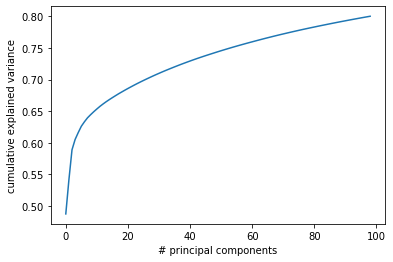

In [44]:

# pca_batch_data = 256
n_compons_rate = 0.8
pca = PCA(n_compons_rate)
pca.fit(X_train)
cum_explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance')

In [45]:

# pca_train_img,pca_inv_img= PCA_decomposition(n_compons_rate,X_train[:pca_batch_data])
# for i in range(pca_batch_data,X_train.shape[0],pca_data):
#         try:
#             pca_img,_= PCA_decomposition(n_comp,X_train[i:i+pca_batch_data])
#             print(pca_img.shape)
#             pca_train_img = np.concatenate([pca_train_img,pca_img])
#         except:
#             print(X_train[i:i+pca_data].shape)


# PCA降維 reconstruct結果

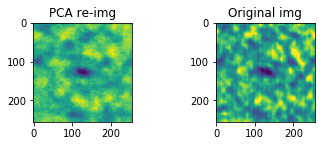

In [49]:
n_compons_rate = 0.8
i = 0

transform_train,pca_inv_img= PCA_decomposition(n_compons_rate,X_train)
re_img = pca_inv_img.reshape((pca_inv_img.shape[0],256,256)).astype(np.uint8)
img_pca = Image.fromarray(re_img[i] ,'L')
plt.subplot(2,2,1)
plt.title('PCA re-img')
plt.imshow(img_pca)
plt.subplot(2,2,2)
plt.title('Original img')
plt.imshow(Image.fromarray(X_train[i].reshape(256,256) ,'L'))
plt.show()

In [50]:

transform_test = pca.transform(X_test)
# for i in range(pca_data,X_test.shape[0],pca_data):
#     try:
#         pca_t_img,_ = PCA_decomposition(n_comp,X_test[i:i+pca_data])
#         pca_test_img = np.concatenate([pca_test_img,pca_t_img])
#     except:
#         re_test = (int(X_test[i:i+pca_data].shape[0]*0.9))
#         print(re_test)
#         pca_remain_img ,_= PCA_decomposition(re_test,X_test[i:i+pca_data])

In [52]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(transform_train,Y_train)
res = knn.predict(transform_test)
res

array([2, 0, 0, ..., 1, 0, 0])

In [53]:
ans = predict_accuracy(res,Y_test)
ans

0.283618984838497

## SVM test

In [54]:
from sklearn import svm

In [58]:
clf = svm.SVC()
clf.fit(transform_train,Y_train)
res = clf.predict(transform_test)
res

array([0, 0, 0, ..., 0, 5, 5])

In [59]:
ans = predict_accuracy(res,Y_test)
ans

0.28526697429136455

In [20]:
# import pandas as pd
# df = pd.read_csv(test_label_file)
# df = df.loc[:,['ID','Label']]
# df.Label = res.astype(int)
# df.head()
# df.to_csv('submission.csv', index=False)